In [147]:
!pip install gdown

In [148]:
!gdown --id 1219EeGE1XTJVXYaulynJSa3BXGsbNCLx

/opt/conda/lib/python3.10/site-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1219EeGE1XTJVXYaulynJSa3BXGsbNCLx
From (redirected): https://drive.google.com/uc?id=1219EeGE1XTJVXYaulynJSa3BXGsbNCLx&confirm=t&uuid=a492b823-cdac-4d06-9edb-91edc82fb4ad
To: /kaggle/working/Archive.zip
100%|███████████████████████████████████████| 1.23G/1.23G [00:03<00:00, 336MB/s]


In [149]:
%%capture
!unzip -o Archive.zip

In [171]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

## Data directory

In [172]:
train_dir = '/kaggle/working/train'
val_dir = '/kaggle/working/val'
test_dir = '/kaggle/working/test'

## Define image dimensions

In [173]:
img_size = 150
batch_size = 16

## Create data generators for training, validation, and testing

In [174]:
datagen = ImageDataGenerator(
    rescale=1 / 255, shear_range=0.2, zoom_range=0.2, horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1 / 255)

## Load data

In [175]:
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode='binary'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_size, img_size),
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Define class labels

In [176]:
class_labels = [label for label, _ in train_generator.class_indices.items()]
num_classes = len(class_labels)
class_labels

['NORMAL', 'PNEUMONIA']

## Display a few sample images

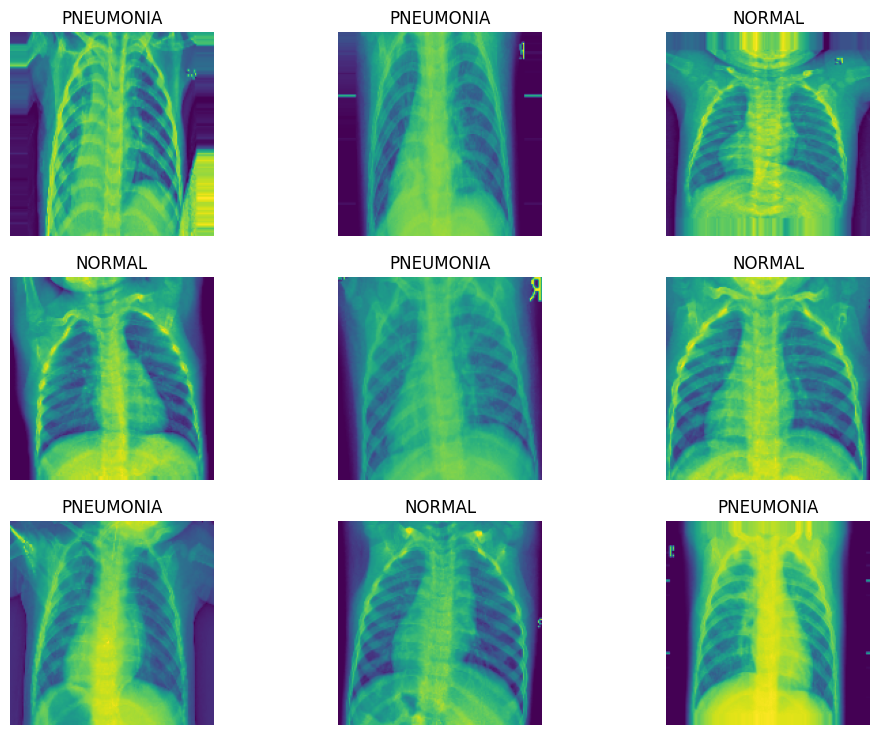

In [177]:
sample_images, sample_labels = next(train_generator)
sample_labels_int = sample_labels.astype(int)

plt.figure(figsize=(12, 9))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    plt.title(class_labels[sample_labels_int[i]])
    plt.axis('off')
plt.show()

# EDA

## Display class distribution for Training Data

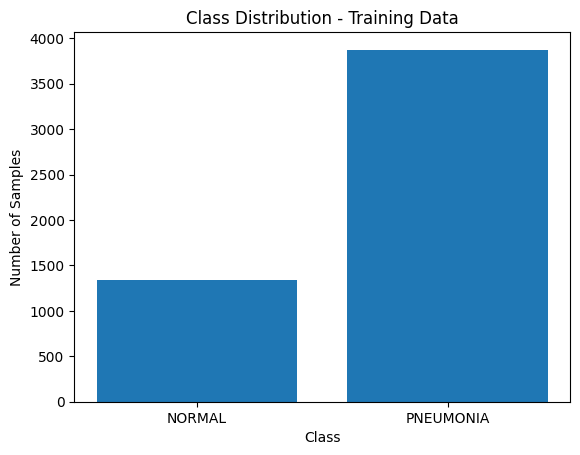

In [178]:
num_train_samples = len(train_generator.filenames)
class_distribution = np.unique(train_generator.classes, return_counts=True)
classes, counts = class_distribution

plt.bar(class_labels, counts)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution - Training Data')
plt.show()

## Display class distribution for Validation Data

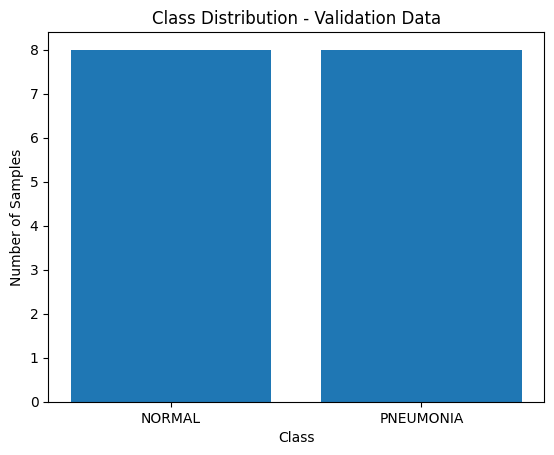

In [179]:
num_val_samples = len(val_generator.filenames)
class_distribution_val = np.unique(val_generator.classes, return_counts=True)
classes_val, counts_val = class_distribution_val

plt.bar(class_labels, counts_val)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution - Validation Data')
plt.show()

## Display class distribution for Test Data

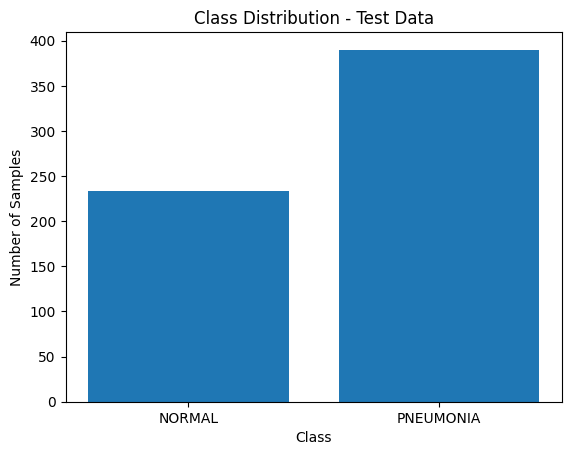

In [180]:
num_test_samples = len(test_generator.filenames)
class_distribution_test = np.unique(test_generator.classes, return_counts=True)
classes_test, counts_test = class_distribution_test

plt.bar(class_labels, counts_test)
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Distribution - Test Data')
plt.show()

# Let's build the model

## Model architecture

In [181]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(img_size, img_size, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

    layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

    layers.Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

    layers.Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

    layers.Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.MaxPooling2D(pool_size=(2, 2), strides=2, padding='same'),

    layers.Flatten(),

    layers.Dense(units=128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_35 (Conv2D)          (None, 150, 150, 32)      320       
                                                                 
 batch_normalization_35 (Ba  (None, 150, 150, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_35 (MaxPooli  (None, 75, 75, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_36 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 dropout_28 (Dropout)        (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_36 (Ba  (None, 75, 75, 64)       

## Model training

In [182]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', patience=2, verbose=1, factor=0.3, min_lr=0.000001)
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/10


2024-01-20 02:30:31.796111: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


326/326 [==============================] - 42s 115ms/step - loss: 0.2904 - accuracy: 0.8965 - val_loss: 11.4619 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
326/326 [==============================] - 37s 114ms/step - loss: 0.1777 - accuracy: 0.9289 - val_loss: 7.4732 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
326/326 [==============================] - 37s 114ms/step - loss: 0.1828 - accuracy: 0.9314 - val_loss: 0.5714 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/10
326/326 [==============================] - 37s 114ms/step - loss: 0.1601 - accuracy: 0.9413 - val_loss: 0.8721 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/10
326/326 [==============================] - ETA: 0s - loss: 0.1401 - accuracy: 0.9509
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
326/326 [==============================] - 37s 114ms/step - loss: 0.1401 - accuracy: 0.9509 - val_loss: 11.4217 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/10
326/326 [==============================] - 38s 

## Evaluation

In [183]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test accuracy:', test_acc)

39/39 [==============================] - 3s 68ms/step - loss: 0.3221 - accuracy: 0.8478
Test accuracy: 0.8477563858032227


In [184]:
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']

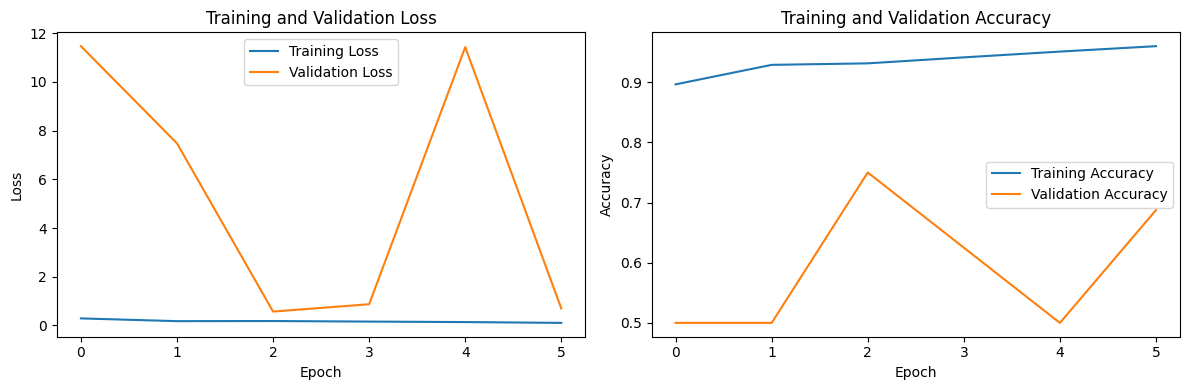

In [185]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Testing model

In [186]:
predictions = model.predict(test_generator)

predicted_labels = (predictions > 0.5).astype(int)

true_labels = test_generator.classes

print(classification_report(true_labels, predicted_labels))

39/39 [==============================] - 3s 68ms/step
              precision    recall  f1-score   support

           0       0.76      0.87      0.81       234
           1       0.92      0.83      0.87       390

    accuracy                           0.85       624
   macro avg       0.84      0.85      0.84       624
weighted avg       0.86      0.85      0.85       624



## ROC curve

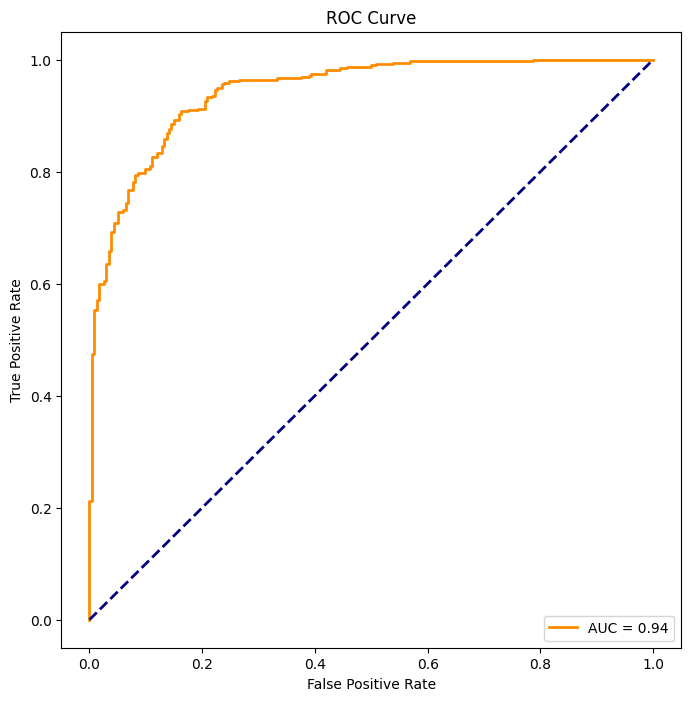

In [187]:
fpr, tpr, thresholds = roc_curve(true_labels, predictions)
roc_auc = roc_auc_score(true_labels, predictions)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

## Confusion matrix

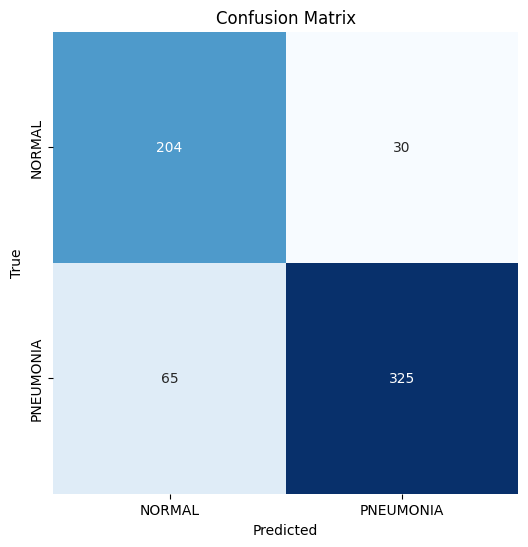

In [188]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()